# Data preprocessing


In [1]:
### Import libraries ### 

import os, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix
import shap

from IPython.display import display
pd.set_option('max_columns', None)

pwd = os.getcwd()

In [2]:
### Info about the data ###

dictionary = pd.read_excel(pwd + '/data/dictionary.xlsx')
with pd.option_context('display.max_colwidth', None):
    display(dictionary)

,Column_name,Description
0,customer_id,Client number. Unique identifier for the customer holding the account\n
1,card_type,"Product Variable - Type of Card (Blue, Silver, Gold, Platinum)"
2,products_count,Total no. of products held by the customer
3,mnths_with_bank,Period of relationship with bank
4,mnths_inactive_last_year,No. of months inactive in the last 12 months
5,contacts_last_year,No. of Contacts in the last 12 months
6,education,"Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)"
7,martial_status,"Demographic variable - Married, Single, Divorced, Unknown"
8,gender,"Demographic variable - M=Male, F=Female"
9,earnings_bucket,"Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown)"


In [3]:
### Load data ###
data = pd.read_csv(pwd + '/data/train.csv')

'''
Based on data below we can define categorical features: 
    - gender
    - martial_status
    - education
    - mnths_inactive_last_year
    - card_type
    - earnings_bucket
'''

print("Type of columns:")
print(data.columns.to_series().groupby(data.dtypes).groups)

print('\nShape of dataset:')
print(data.shape)

### Show first 5 rows 
data.head(5)

Type of columns:
{int64: ['customer_id', 'products_count', 'mnths_inactive_last_year', 'contacts_last_year', 'age', 'family_size', 'revolving_balance', 'TARGET'], float64: ['mnths_with_bank', 'cc_limit', 'trans_amount', 'trans_count', 'amount_change', 'count_change', 'open_to_buy_cl', 'util_ratio'], object: ['card_type', 'education', 'martial_status', 'gender', 'earnings_bucket']}

Shape of dataset:
(11798, 21)


,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,TARGET
0,766285608,Blue,4,35.0,3,3,High School,Single,M,$40K - $60K,42,3,3266.0,2183.0,56.0,1.568,0.750,1900,1366.0,0.582,0
1,716452908,Blue,4,36.0,2,3,Unknown,Single,F,Less than $40K,36,1,9239.0,2246.0,44.0,0.823,0.833,1421,7818.0,0.154,0
2,711671058,Blue,5,38.0,2,2,Uneducated,Married,F,Unknown,48,1,1438.3,2171.0,38.0,0.574,0.462,0,1438.3,0.000,1
3,720108783,Blue,6,50.0,3,3,Uneducated,Single,F,Unknown,60,1,7459.0,4328.0,68.0,1.001,0.581,1717,5742.0,0.230,0
4,786493908,Silver,4,36.0,3,3,Uneducated,Single,F,Less than $40K,42,4,10091.0,3347.0,64.0,1.121,0.778,0,10091.0,0.000,0


In [4]:
### Check if there is any duplicated row ###
print("Shape of original dataset: {}".format(data.shape))
print("Number of unique customers: {} \n".format(data["customer_id"].nunique()))
print(data["customer_id"].value_counts())

# Check if the whole example row is identical
display(data[data["customer_id"] == 766285608])

data = data.drop_duplicates()
print("\nShape of data after removing duplicated rows: {}".format(data.shape))


Shape of original dataset: (11798, 21)
Number of unique customers: 9114 

766285608    2
757167633    2
787501758    2
788846508    2
818502708    2
            ..
711862533    1
708702258    1
711765708    1
715872333    1
804403908    1
Name: customer_id, Length: 9114, dtype: int64


,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,TARGET
0,766285608,Blue,4,35.0,3,3,High School,Single,M,$40K - $60K,42,3,3266.0,2183.0,56.0,1.568,0.75,1900,1366.0,0.582,0
9114,766285608,Blue,4,35.0,3,3,High School,Single,M,$40K - $60K,42,3,3266.0,2183.0,56.0,1.568,0.75,1900,1366.0,0.582,0



Shape of data after removing duplicated rows: (9114, 21)


In [5]:
### Check empty values ###
print("Check how many empty values we have:")
print(data.isna().sum())

Check how many empty values we have:
customer_id                   0
card_type                     0
products_count                0
mnths_with_bank             161
mnths_inactive_last_year      0
contacts_last_year            0
education                   167
martial_status                0
gender                       98
earnings_bucket               0
age                           0
family_size                   0
cc_limit                      0
trans_amount                134
trans_count                 129
amount_change                 0
count_change                  0
revolving_balance             0
open_to_buy_cl                0
util_ratio                    0
TARGET                        0
dtype: int64


In [6]:
### Handle missing values ###

#String columns with empty values: gender, education
print(data["education"].value_counts())
# If there is a column Unknow, we can use the same word for rows, where we do not have data, as we simply do not know 
data.education = data.education.fillna('Unknown')
print(data["education"].value_counts())

print(data["gender"].value_counts())
data.gender = data.gender.fillna('no data')
print(data["gender"].value_counts())

### Numeric columns with empty values: mnths_with_bank, trans_amount,trans_count                            
# We can test different varaints here: -1, mean, mediana etc. 
data = data.fillna(-1)
print(data.isna().sum())

Graduate         2778
High School      1768
Unknown          1343
Uneducated       1298
College           907
Post-Graduate     456
Doctorate         397
Name: education, dtype: int64
Graduate         2778
High School      1768
Unknown          1510
Uneducated       1298
College           907
Post-Graduate     456
Doctorate         397
Name: education, dtype: int64
F    4785
M    4231
Name: gender, dtype: int64
F          4785
M          4231
no data      98
Name: gender, dtype: int64
customer_id                 0
card_type                   0
products_count              0
mnths_with_bank             0
mnths_inactive_last_year    0
contacts_last_year          0
education                   0
martial_status              0
gender                      0
earnings_bucket             0
age                         0
family_size                 0
cc_limit                    0
trans_amount                0
trans_count                 0
amount_change               0
count_change                0


In [7]:
### Data info - to double check if there is no empty value which has been left in our dataset ###
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9114 entries, 0 to 9113
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               9114 non-null   int64  
 1   card_type                 9114 non-null   object 
 2   products_count            9114 non-null   int64  
 3   mnths_with_bank           9114 non-null   float64
 4   mnths_inactive_last_year  9114 non-null   int64  
 5   contacts_last_year        9114 non-null   int64  
 6   education                 9114 non-null   object 
 7   martial_status            9114 non-null   object 
 8   gender                    9114 non-null   object 
 9   earnings_bucket           9114 non-null   object 
 10  age                       9114 non-null   int64  
 11  family_size               9114 non-null   int64  
 12  cc_limit                  9114 non-null   float64
 13  trans_amount              9114 non-null   float64
 14  trans_co

In [8]:
### Data Statistics ###
data.describe()

,customer_id,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,TARGET
count,9.114000e+03,9114.000000,9114.000000,9114.000000,9114.000000,9114.000000,9114.000000,9114.000000,9114.000000,9114.000000,9114.000000,9114.000000,9114.000000,9114.000000,9114.000000,9114.000000
mean,7.392386e+08,3.801734,35.280557,2.345512,2.456660,48.246873,2.349353,8632.526761,4357.189379,63.948760,0.759739,0.712002,1164.060127,7468.466634,0.275628,0.160632
std,3.696426e+07,1.554198,9.294218,1.015786,1.106894,22.780178,1.297664,9089.716024,3436.942284,24.537489,0.218552,0.236566,815.705169,9091.577244,0.276548,0.367211
min,7.080821e+08,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1438.300000,-1.000000,-1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
25%,7.130545e+08,3.000000,31.000000,2.000000,2.000000,41.000000,1.000000,2558.500000,2107.250000,44.000000,0.631000,0.582000,365.000000,1314.250000,0.023000,0.000000
50%,7.179553e+08,4.000000,36.000000,2.000000,2.000000,46.000000,2.000000,4532.500000,3875.500000,67.000000,0.736000,0.702000,1278.000000,3484.000000,0.175000,0.000000
75%,7.732176e+08,5.000000,40.000000,3.000000,3.000000,52.000000,3.000000,11108.500000,4734.000000,80.000000,0.858000,0.818000,1784.750000,9882.250000,0.504000,0.000000
max,8.283431e+08,6.000000,56.000000,6.000000,6.000000,200.000000,5.000000,34516.000000,18484.000000,139.000000,3.397000,3.714000,2517.000000,34516.000000,0.999000,1.000000


0    7650
1    1464
Name: TARGET, dtype: int64


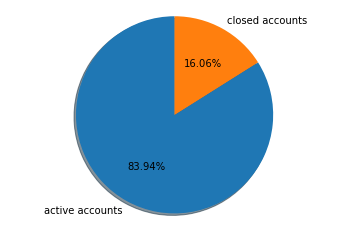

In [9]:
### Check target variable distribution: 1 - closed account, 0 - active account ###
print(data["TARGET"].value_counts())
labels = ['active accounts', 'closed accounts']
sizes = [data["TARGET"].value_counts()[0], data["TARGET"].value_counts()[1]]
fig, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.2f%%',
        shadow = True, startangle = 90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Split data to train and test datasets


In [10]:
### Train and test datasets ###
X = data.drop(["TARGET"], axis = 'columns')
y = data["TARGET"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Check distributed of classes
X['test'] = y
print(X["test"].value_counts())

# Remove customer_id from training and testing datasets 
customer_id_train_test = X['customer_id']
X_train = X_train.drop('customer_id', axis = 1)
X_test = X_test.drop('customer_id', axis = 1)

0    7650
1    1464
Name: test, dtype: int64


# Check correcation between features

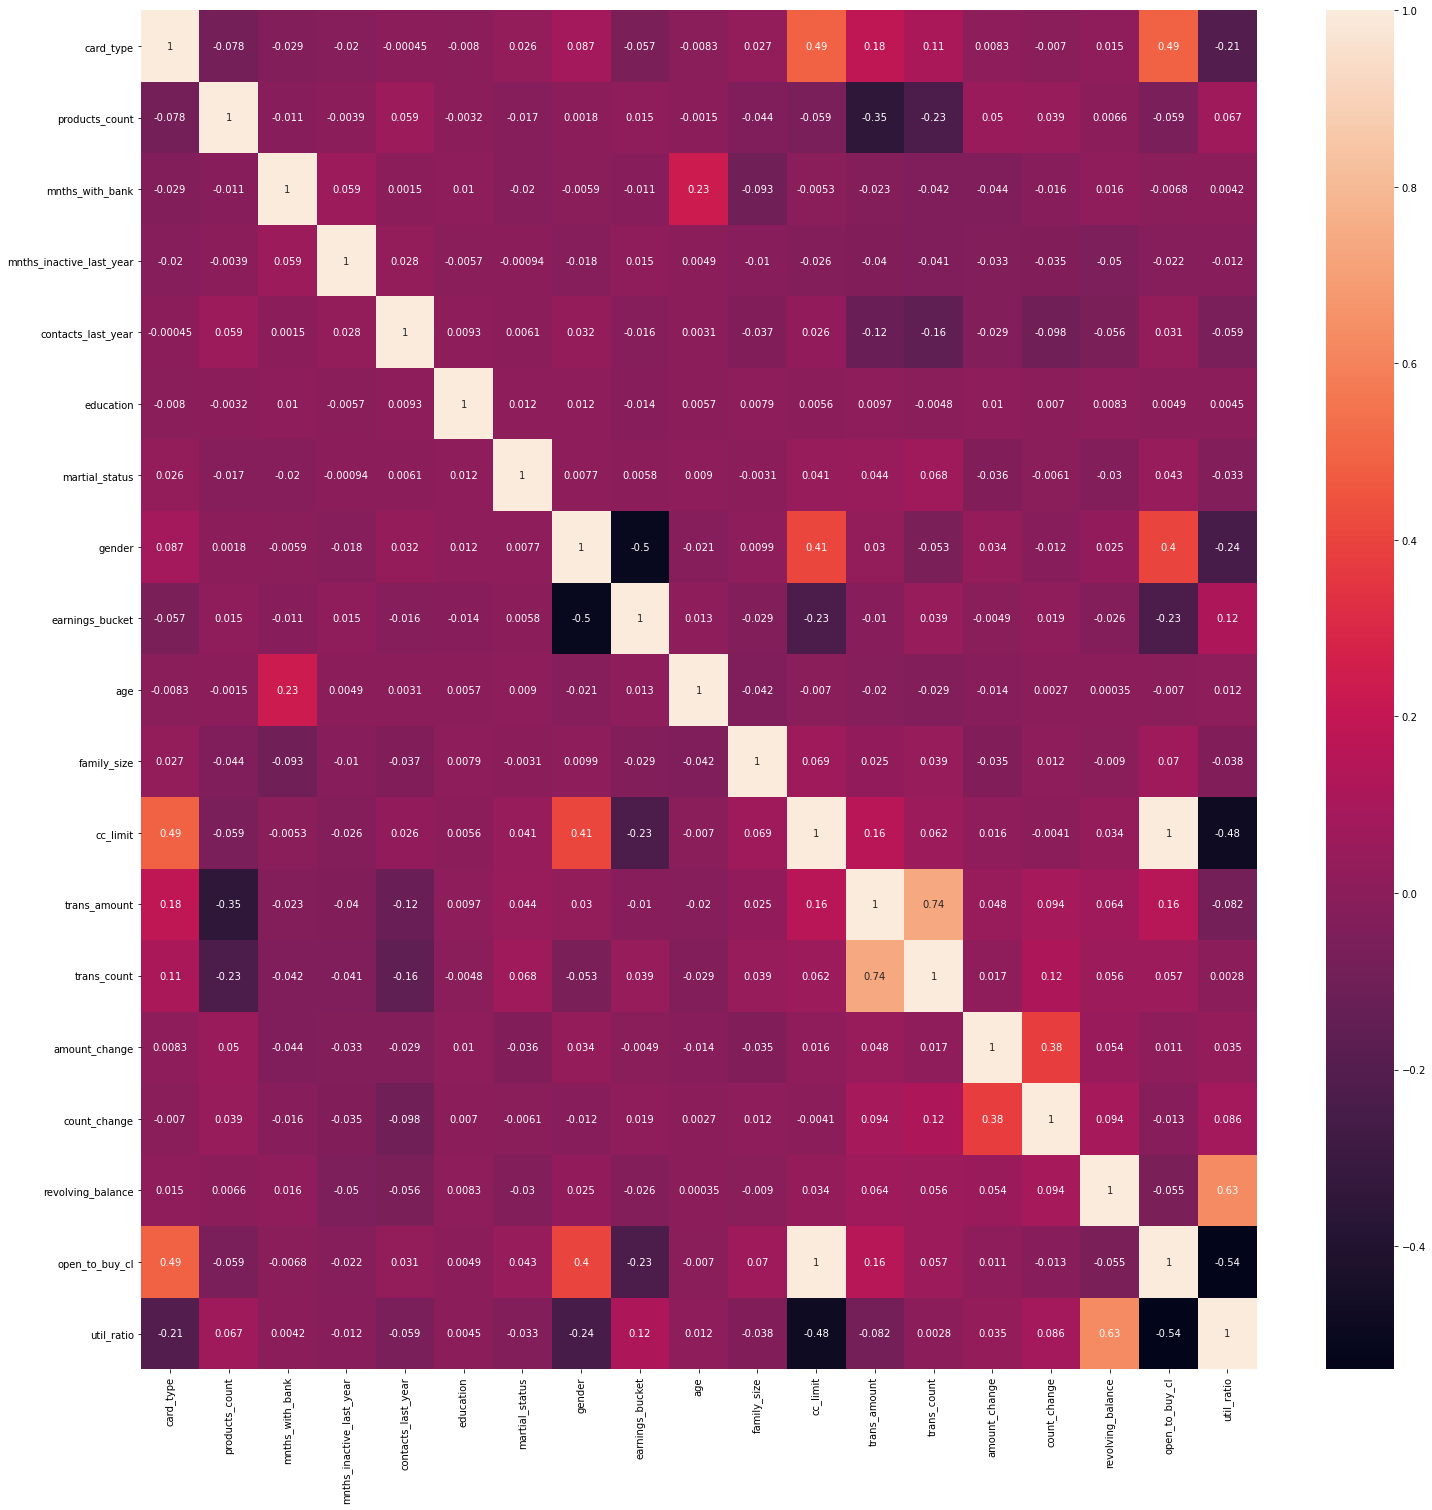

In [11]:
'''
We can notice that correlation between cc_limit and open_to_buy_cl features is equal to 1, 
so it simply means that one feature is explained by the other.
We can skip one features to do not provide redundant information to our model (but for now I will keep both of them). 
'''

### Data encoding ###
datat_to_corr = X_train
label_encoder = LabelEncoder()
categorical_features = ['gender', 'martial_status', 'education', 'mnths_inactive_last_year', 'card_type', 'earnings_bucket']

for i in categorical_features:
    datat_to_corr[i] = label_encoder.fit_transform(datat_to_corr[i])
    
### Correlation matrix ###
datat_to_corr.head()
to_corr = datat_to_corr[[ 'card_type', 'products_count', 'mnths_with_bank','mnths_inactive_last_year', 'contacts_last_year',\
             'education','martial_status', 'gender', 'earnings_bucket', 'age', 'family_size','cc_limit',\
             'trans_amount', 'trans_count', 'amount_change', 'count_change', 'revolving_balance', \
             'open_to_buy_cl', 'util_ratio']]
corr_matrix = to_corr.corr()
plt.figure(figsize = (25,25)) 
sns.heatmap(corr_matrix, annot = True)
plt.show()

# Train the model  - CATBOOST ALGORITHM


In [12]:
### Train the model << CATBOOST ALGORITHM >>

cat_features = ['gender', 'martial_status', 'education', 'mnths_inactive_last_year', 'card_type', 'earnings_bucket']

train_dataset = Pool(data = X_train,
                     label = y_train, 
                    cat_features = cat_features)

test_dataset = Pool(data = X_test,
                    label = y_test, 
                   cat_features = cat_features)

# Initialize CatBoostClassifier
model = CatBoostClassifier( iterations = 50,
                            random_seed = 42,
                            learning_rate = 0.5,
                            loss_function ='Logloss', 
                             custom_metric = ['Logloss',
                                          'AUC:hints=skip_train~false', 
                                            'Accuracy'])
#Fit model
model.fit(train_dataset)
# Get predicted classes
preds_class = model.predict(test_dataset)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(test_dataset)
# Get predicted RawFormulaVal
preds_raw = model.predict(test_dataset,
                          prediction_type = 'RawFormulaVal')

print(model.get_best_score())
print('CatBoost model parameters:')
print(model.get_params())
model.fit(
    X_train, y_train,
    cat_features = cat_features,
    eval_set = (X_test, y_test),
    verbose = False,
    plot = True
)

0:	learn: 0.4323827	total: 214ms	remaining: 10.5s
1:	learn: 0.3340253	total: 289ms	remaining: 6.93s
2:	learn: 0.2701957	total: 348ms	remaining: 5.45s
3:	learn: 0.2277187	total: 417ms	remaining: 4.79s
4:	learn: 0.2074400	total: 479ms	remaining: 4.31s
5:	learn: 0.1808784	total: 547ms	remaining: 4.01s
6:	learn: 0.1665481	total: 615ms	remaining: 3.78s
7:	learn: 0.1520686	total: 681ms	remaining: 3.57s
8:	learn: 0.1460680	total: 750ms	remaining: 3.42s
9:	learn: 0.1399999	total: 818ms	remaining: 3.27s
10:	learn: 0.1300219	total: 890ms	remaining: 3.16s
11:	learn: 0.1237492	total: 960ms	remaining: 3.04s
12:	learn: 0.1169040	total: 1.03s	remaining: 2.94s
13:	learn: 0.1130986	total: 1.11s	remaining: 2.85s
14:	learn: 0.1098574	total: 1.19s	remaining: 2.79s
15:	learn: 0.1062632	total: 1.26s	remaining: 2.68s
16:	learn: 0.1041356	total: 1.34s	remaining: 2.6s
17:	learn: 0.1016236	total: 1.41s	remaining: 2.5s
18:	learn: 0.0966880	total: 1.47s	remaining: 2.41s
19:	learn: 0.0954366	total: 1.54s	remaining

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Results

In [13]:
### Add prediction and certainty columns to dataset ###
X_test['prediction'] = preds_class
X_test['certainty'] = np.max(preds_proba, axis = 1)
X_test.head(10)

,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction,certainty
6511,Blue,5,47.0,6,2,Graduate,Married,F,Less than $40K,53,3,2759.0,2093.0,42.0,1.320,1.000,2223,536.0,0.806,0,0.998535
6521,Blue,6,47.0,3,2,Unknown,Married,F,Less than $40K,52,3,2280.0,1924.0,50.0,0.603,0.667,1170,1110.0,0.513,0,0.968955
1287,Blue,1,32.0,2,2,High School,Single,M,$40K - $60K,46,2,2000.0,7694.0,85.0,0.821,0.700,1739,261.0,0.870,0,0.996947
8048,Blue,4,30.0,3,2,Graduate,Divorced,F,Less than $40K,0,4,1791.0,5109.0,79.0,0.725,0.756,1314,477.0,0.734,0,0.996956
1606,Blue,4,36.0,2,2,Graduate,Married,F,Less than $40K,42,3,2526.0,4267.0,72.0,0.716,0.800,2048,478.0,0.811,0,0.999418
5809,Blue,5,45.0,3,1,Unknown,Single,F,$40K - $60K,52,3,6053.0,5035.0,64.0,0.850,1.370,577,5476.0,0.095,0,0.961846
6399,Blue,3,35.0,2,2,Uneducated,Married,M,$40K - $60K,46,4,9149.0,1790.0,60.0,0.971,0.765,1566,7583.0,0.171,0,0.994830
6006,Blue,5,36.0,3,2,College,Single,M,$60K - $80K,29,1,5346.0,3253.0,80.0,0.928,0.818,0,5346.0,0.000,0,0.991046
1076,Blue,3,41.0,3,1,Unknown,Single,M,$80K - $120K,52,2,2757.0,3992.0,76.0,0.574,1.054,1425,1332.0,0.517,0,0.999264
1840,Blue,6,36.0,3,3,College,Married,F,Less than $40K,47,2,1438.3,3832.0,87.0,0.634,0.673,0,1438.3,0.000,0,0.998260


# Confusion matrix

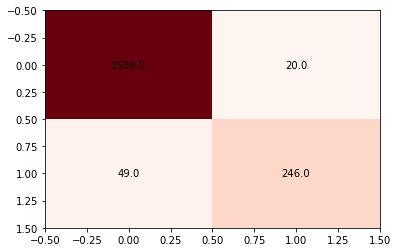

In [14]:
### Confusion matrix ###
cm = get_confusion_matrix(model, Pool(data = X_test, label = y_test,  cat_features = cat_features))

fig1, ax1 = plt.subplots(1, sharex = True, sharey = False)
ax1.imshow(cm,  cmap ='Reds', aspect = 'auto')
for (j,i),label in np.ndenumerate(cm):
    ax1.text(i,j,label,ha ='center',va ='center')
plt.show()  

# ROC curve and Precision-recall curve

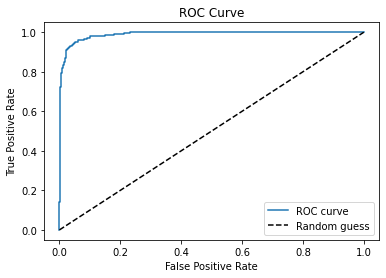

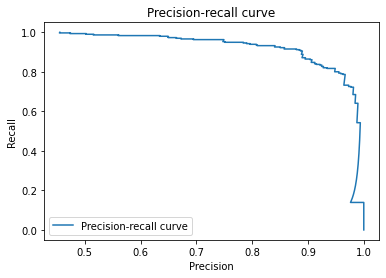

In [15]:
###  ROC Curve ###
fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label = 'ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label = 'Random guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC Curve')
plt.legend(loc = "lower right")
plt.show()

### Precision-recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(precision, recall, label = 'Precision-recall curve')
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-recall curve")
plt.legend(loc = "lower left")
plt.show()

# Feature importance

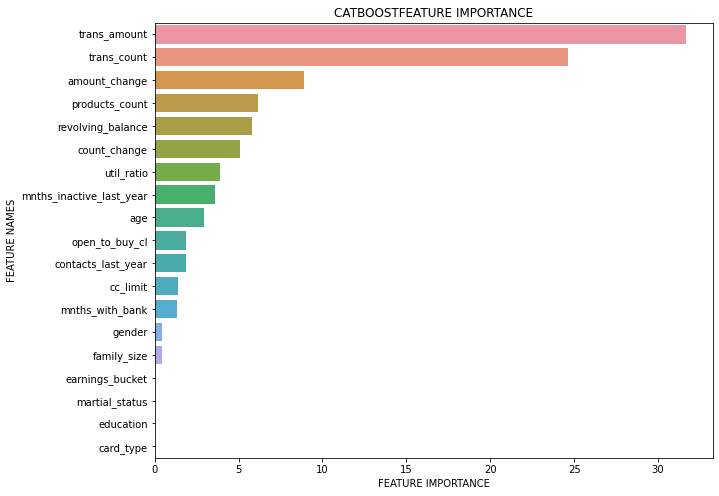

In [16]:
### Feature importance ###
        
def plot_feature_importance(importance, names, model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data = {'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by = ['feature_importance'], ascending = False, inplace = True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
pd.DataFrame({'feature_importance': model.get_feature_importance(train_dataset), 
              'feature_names': X_train.columns}).sort_values(by = ['feature_importance'], 
                                                           ascending = False)
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')

# SHAP explainability

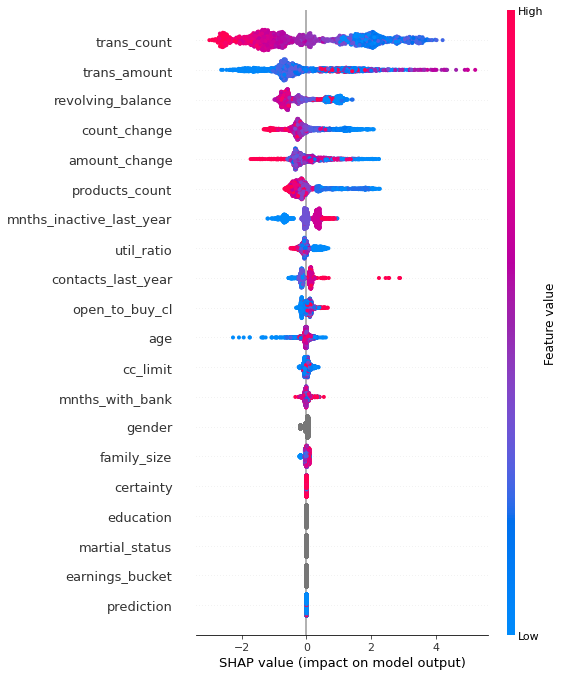

In [17]:
### SHAP explainability - explain why our model decided how decided 
'''
To better understand the results of our model we can use for example SHAP examplinability module, 
which allow us to check which feature and how affect on our model. 
We can analyze case by case eg. it is good to check results with the highest and the lowest certainty, 
cases where we had empty values, cases which were wrongly classified etc. 
'''
#load JS visualization code to notebook
shap.initjs()
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


# SHAP  - some exmples for individual observations

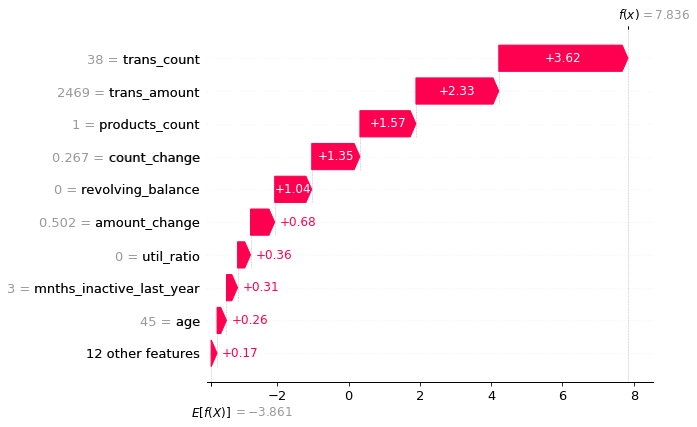

,index,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction,certainty
1344,8650,Blue,1,33.0,3,4,Unknown,Single,F,Less than $40K,45,2,1492.0,2469.0,38.0,0.502,0.267,0,1492.0,0.0,1,0.999556


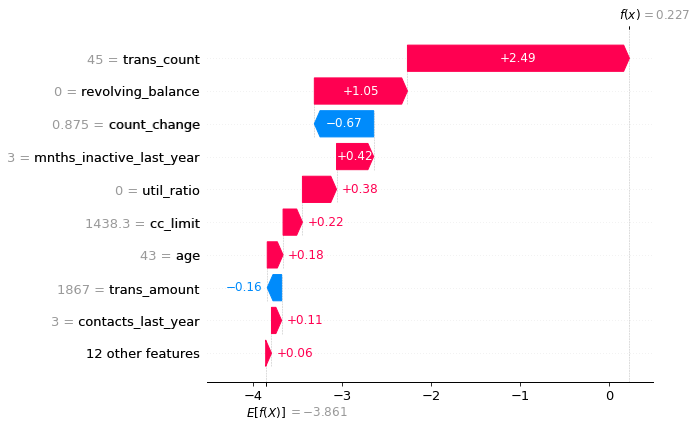

,index,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction,certainty
236,6195,Blue,3,31.0,3,3,Graduate,Single,M,$120K +,43,3,1438.3,1867.0,45.0,0.663,0.875,0,1438.3,0.0,1,0.527456


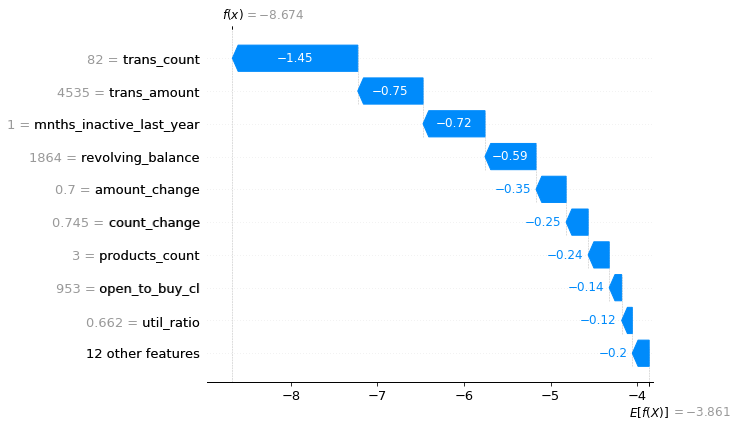

,index,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction,certainty
300,7440,Blue,3,44.0,1,2,College,Single,F,$40K - $60K,57,3,2817.0,4535.0,82.0,0.7,0.745,1864,953.0,0.662,0,0.999841


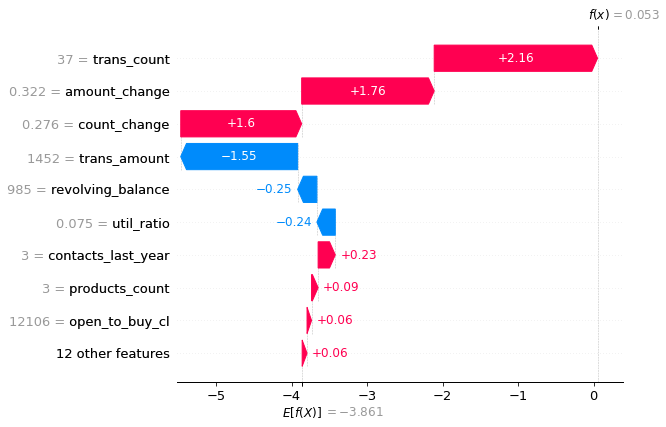

,index,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction,certainty
229,76,Blue,3,39.0,2,3,High School,Married,M,$120K +,53,2,13091.0,1452.0,37.0,0.322,0.276,985,12106.0,0.075,0,0.501389


In [18]:
### Now let's look at individual examples
'''

1. Model predicted with high confidence that the account is gonna be closed.
2. Model predicted with low confidence that the account is gonna be closed.
3. Model predicted with high confidence that the account is gonna stay active.
4. Model predicted with low confidence that the account is gonna stay acive.

'''
X_test = X_test.reset_index()
idx_1 = X_test[X_test['prediction'] == 1].sort_values(by = 'certainty', ascending = False).head(1).index[0]
idx_2 = X_test[X_test['prediction'] == 1].sort_values(by = 'certainty', ascending = True).head(1).index[0]
idx_3 = X_test[X_test['prediction'] == 0].sort_values(by = 'certainty', ascending = False).head(1).index[0]
idx_4 = X_test[X_test['prediction'] == 0].sort_values(by = 'certainty', ascending = True).head(1).index[0]
indexes = [idx_1, idx_2, idx_3, idx_4]

for i in indexes:
    shap.plots.waterfall(shap_values[i])
    display(X_test.iloc[[i]])

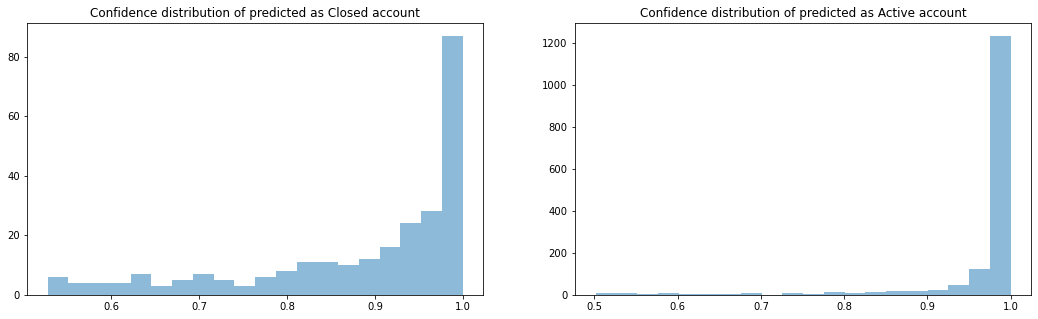

In [19]:
### Check the distribution of confidence for both predicted classes ###

closed_accounts = X_test[X_test['prediction'] == 1]
closed = closed_accounts['certainty'].tolist()
active_accounts = X_test[X_test['prediction'] == 0]
active = active_accounts['certainty'].tolist()

bins = 20
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
plt.title("Confidence distribution of predicted as Closed account")
plt.hist(closed, bins, alpha = 0.5, label = 'closed')
plt.subplot(1,2,2)
plt.title("Confidence distribution of predicted as Active account")
plt.hist(active, bins, alpha = 0.5, label = 'active')
plt.show()

# Evaluate model on unlabelled test data

In [20]:
### Load test dataset ###
test_data = pd.read_csv(pwd + '/data/test.csv')
test_data_without_predictions = test_data
print("Type of columns:")
print(test_data.columns.to_series().groupby(test_data.dtypes).groups)

print('\nShape of dataset:')
print(test_data.shape)

### Show first 5 rows 
test_data.head(5)

Type of columns:
{int64: ['customer_id', 'products_count', 'mnths_inactive_last_year', 'contacts_last_year', 'age', 'family_size', 'revolving_balance'], float64: ['mnths_with_bank', 'cc_limit', 'trans_amount', 'trans_count', 'amount_change', 'count_change', 'open_to_buy_cl', 'util_ratio'], object: ['card_type', 'education', 'martial_status', 'gender', 'earnings_bucket']}

Shape of dataset:
(1013, 20)


,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio
0,715412583,Blue,6,36.0,1,4,Post-Graduate,Married,M,$40K - $60K,51,3,7925.0,3815.0,65.0,0.750,0.806,1445,6480.0,0.182
1,708515358,Blue,6,36.0,3,2,High School,Married,F,Less than $40K,40,1,4712.0,4216.0,82.0,0.840,0.640,0,4712.0,0.000
2,755305683,Blue,5,38.0,1,4,Graduate,Married,M,$60K - $80K,45,5,8983.0,15163.0,124.0,0.713,0.746,0,8983.0,0.000
3,719147208,Blue,4,21.0,3,2,Unknown,Single,F,Less than $40K,29,2,2298.0,4814.0,88.0,0.776,0.630,0,2298.0,0.000
4,711626658,Blue,2,36.0,3,4,High School,Single,F,Less than $40K,62,1,1930.0,1971.0,45.0,0.331,0.250,0,1930.0,0.000


# Preprocessing of newly loaded data 

In [21]:
### Check if there is any duplicated row ###
print("Shape of original dataset: {}".format(test_data.shape))
print("Number of unique customers: {} \n".format(test_data["customer_id"].nunique()))


Shape of original dataset: (1013, 20)
Number of unique customers: 1013 



In [22]:
### Check empty values ###
print("Check how many empty values we have:")
print(test_data.isna().sum())

Check how many empty values we have:
customer_id                  0
card_type                    0
products_count               0
mnths_with_bank             14
mnths_inactive_last_year     0
contacts_last_year           0
education                   22
martial_status               0
gender                       3
earnings_bucket              0
age                          0
family_size                  0
cc_limit                     0
trans_amount                20
trans_count                 13
amount_change                0
count_change                 0
revolving_balance            0
open_to_buy_cl               0
util_ratio                   0
dtype: int64


In [23]:
### Handle missing values ###

# String columns with empty values: gender, education
print(test_data["education"].value_counts())
# If there is a column Unknow, we can use the same word for rows, where we do not have data, as we simply do not know 
test_data.education = test_data.education.fillna('Unknown')
print(test_data["education"].value_counts())

print(test_data["gender"].value_counts())
test_data.gender = test_data.gender.fillna('no data')
print(test_data["gender"].value_counts())

# Numeric columns with empty values: mnths_with_bank, trans_amount,trans_count                            
# We can test different varaints here: -1, mean, mediana etc. 
test_data = test_data.fillna(-1)
print(test_data.isna().sum())

Graduate         297
High School      205
Uneducated       159
Unknown          147
College           89
Post-Graduate     47
Doctorate         47
Name: education, dtype: int64
Graduate         297
High School      205
Unknown          169
Uneducated       159
College           89
Post-Graduate     47
Doctorate         47
Name: education, dtype: int64
F    523
M    487
Name: gender, dtype: int64
F          523
M          487
no data      3
Name: gender, dtype: int64
customer_id                 0
card_type                   0
products_count              0
mnths_with_bank             0
mnths_inactive_last_year    0
contacts_last_year          0
education                   0
martial_status              0
gender                      0
earnings_bucket             0
age                         0
family_size                 0
cc_limit                    0
trans_amount                0
trans_count                 0
amount_change               0
count_change                0
revolving_balance  

In [24]:
### Data info - to double check if there is no empty value which has been left in our dataset ###
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               1013 non-null   int64  
 1   card_type                 1013 non-null   object 
 2   products_count            1013 non-null   int64  
 3   mnths_with_bank           1013 non-null   float64
 4   mnths_inactive_last_year  1013 non-null   int64  
 5   contacts_last_year        1013 non-null   int64  
 6   education                 1013 non-null   object 
 7   martial_status            1013 non-null   object 
 8   gender                    1013 non-null   object 
 9   earnings_bucket           1013 non-null   object 
 10  age                       1013 non-null   int64  
 11  family_size               1013 non-null   int64  
 12  cc_limit                  1013 non-null   float64
 13  trans_amount              1013 non-null   float64
 14  trans_co

In [25]:
### Data Statistics ###
test_data.describe()

,customer_id,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio
count,1.013000e+03,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000
mean,7.386291e+08,3.910168,35.334650,2.302073,2.443238,48.375123,2.317868,8626.797828,4202.848963,63.588351,0.761755,0.714205,1151.603159,7475.194669,0.268283
std,3.636858e+07,1.553660,9.062778,0.962522,1.100658,24.629577,1.310360,9084.805218,3240.812527,24.347439,0.225113,0.251461,808.813958,9087.141751,0.267903
min,7.080992e+08,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1438.300000,-1.000000,-1.000000,0.196000,0.053000,0.000000,41.000000,0.000000
25%,7.129717e+08,3.000000,31.000000,2.000000,2.000000,40.000000,1.000000,2536.000000,2108.000000,44.000000,0.625000,0.580000,331.000000,1438.300000,0.019000
50%,7.176501e+08,4.000000,36.000000,2.000000,2.000000,47.000000,2.000000,4726.000000,3847.000000,66.000000,0.738000,0.698000,1253.000000,3388.000000,0.181000
75%,7.726880e+08,5.000000,40.000000,3.000000,3.000000,52.000000,3.000000,10677.000000,4664.000000,80.000000,0.867000,0.824000,1768.000000,9673.000000,0.476000
max,8.282155e+08,6.000000,56.000000,6.000000,6.000000,200.000000,5.000000,34516.000000,16908.000000,130.000000,2.357000,3.500000,2517.000000,34516.000000,0.983000


In [26]:
### Remove customer_id from test datset 
customer_id_column = test_data.pop('customer_id')

# Making predictions on unlabelled test data

In [27]:
### Infer an already trained model ###
test_dataset = Pool(data = test_data, 
                   cat_features = cat_features)

preds_class = model.predict(test_dataset)

### Add prediction column to dataset ###
test_data['prediction'] = preds_class

In [28]:
### Check distrubution of our predictions 0 - active account, 1 closed account 
test_data['prediction'].value_counts()

0    877
1    136
Name: prediction, dtype: int64

# SHAP explainability

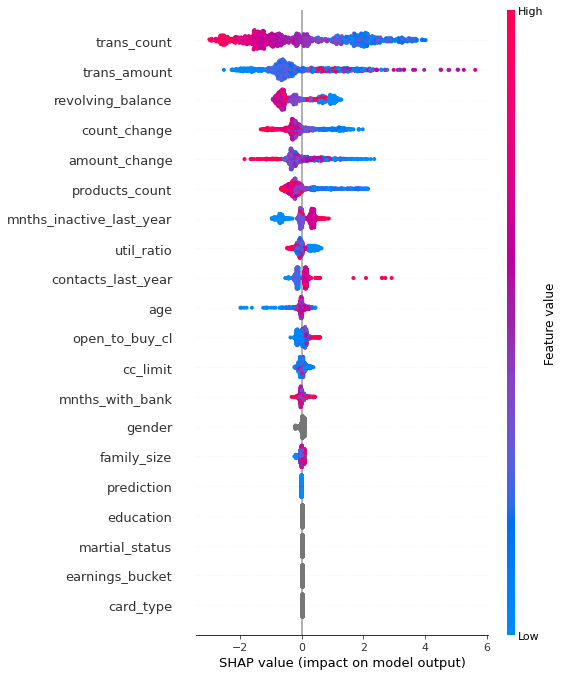

In [29]:
shap.initjs()
explainer = shap.Explainer(model)
shap_values = explainer(test_data)

# Summary plot
shap.summary_plot(shap_values, test_data)

In [30]:
# Add customer_id column back 
test_data.insert(0, 'customer_id', customer_id_column)
test_data.head(5)

### Saving data with predictions to .csv file
test_data.to_csv(pwd + '/data/test_data_with_predictions.csv', index=False)

# Check if data has been saved correctly
t = pd.read_csv(pwd + '/data/test_data_with_predictions.csv')
t.head(5)

,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction
0,715412583,Blue,6,36.0,1,4,Post-Graduate,Married,M,$40K - $60K,51,3,7925.0,3815.0,65.0,0.750,0.806,1445,6480.0,0.182,0
1,708515358,Blue,6,36.0,3,2,High School,Married,F,Less than $40K,40,1,4712.0,4216.0,82.0,0.840,0.640,0,4712.0,0.000,0
2,755305683,Blue,5,38.0,1,4,Graduate,Married,M,$60K - $80K,45,5,8983.0,15163.0,124.0,0.713,0.746,0,8983.0,0.000,0
3,719147208,Blue,4,21.0,3,2,Unknown,Single,F,Less than $40K,29,2,2298.0,4814.0,88.0,0.776,0.630,0,2298.0,0.000,0
4,711626658,Blue,2,36.0,3,4,High School,Single,F,Less than $40K,62,1,1930.0,1971.0,45.0,0.331,0.250,0,1930.0,0.000,1


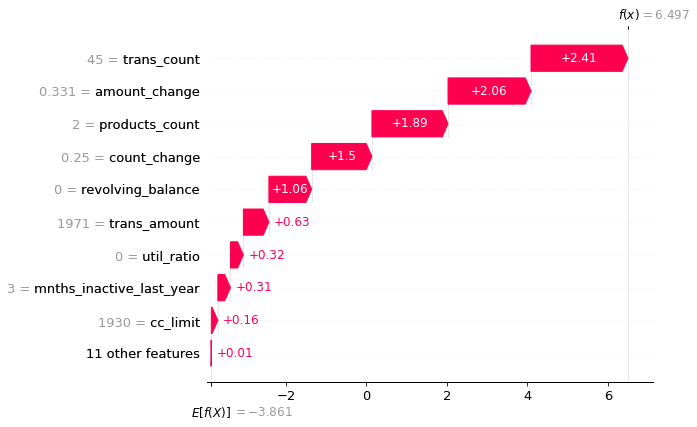

,index,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction
4,4,711626658,Blue,2,36.0,3,4,High School,Single,F,Less than $40K,62,1,1930.0,1971.0,45.0,0.331,0.25,0,1930.0,0.0,1


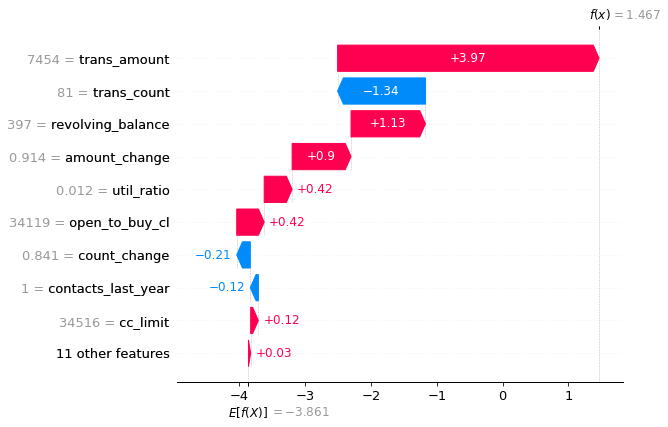

,index,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction
9,9,715830558,Blue,6,38.0,2,1,Unknown,Unknown,M,$120K +,50,2,34516.0,7454.0,81.0,0.914,0.841,397,34119.0,0.012,1


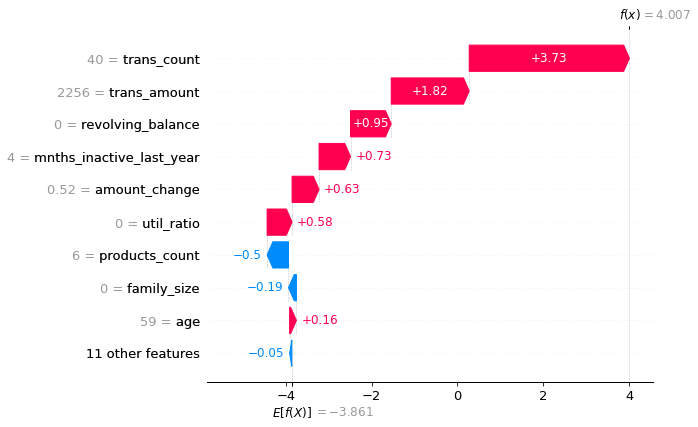

,index,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction
15,15,714372333,Blue,6,52.0,4,2,Doctorate,Married,F,Less than $40K,59,0,2302.0,2256.0,40.0,0.52,0.667,0,2302.0,0.0,1


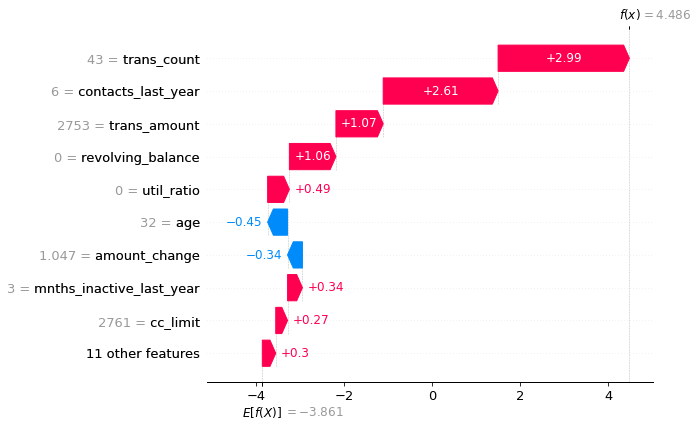

,index,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction
23,23,716625033,Blue,3,36.0,3,6,Graduate,Single,F,Less than $40K,32,1,2761.0,2753.0,43.0,1.047,0.654,0,2761.0,0.0,1


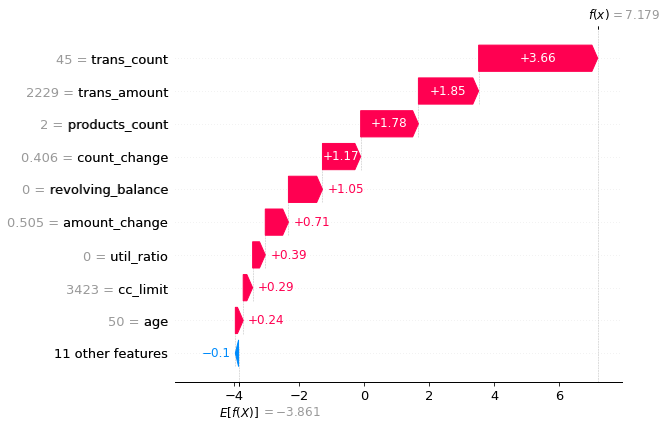

,index,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction
28,28,713512308,Blue,2,41.0,3,1,Graduate,Single,F,Less than $40K,50,0,3423.0,2229.0,45.0,0.505,0.406,0,3423.0,0.0,1


In [31]:
# We can chceck 5 observations, when our model decided that those account will gonna closed 
# Red colour represents value which encouraged model to say that this account will going to be closed. Blue one is opposite. 

test_data = test_data.reset_index()
idx_closed = test_data[test_data['prediction'] == 1].head(5).index

for i in idx_closed:
    shap.plots.waterfall(shap_values[i])
    display(test_data.iloc[[i]])

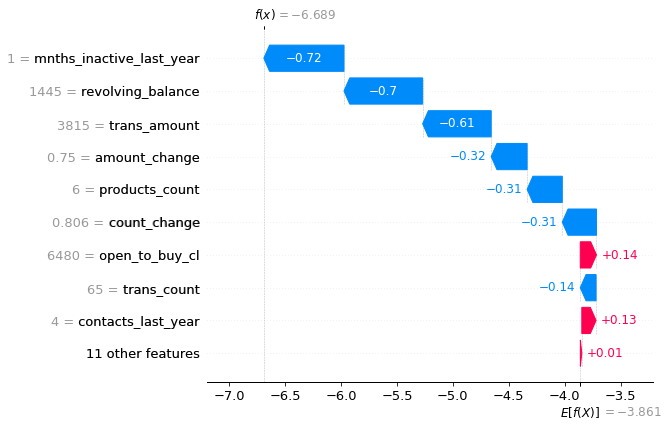

,index,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction
0,0,715412583,Blue,6,36.0,1,4,Post-Graduate,Married,M,$40K - $60K,51,3,7925.0,3815.0,65.0,0.75,0.806,1445,6480.0,0.182,0


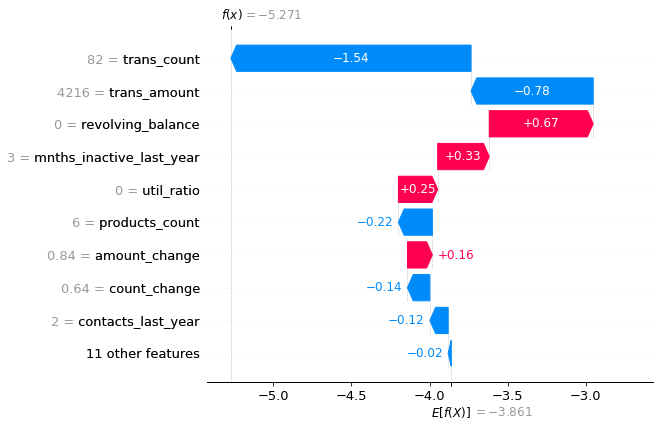

,index,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction
1,1,708515358,Blue,6,36.0,3,2,High School,Married,F,Less than $40K,40,1,4712.0,4216.0,82.0,0.84,0.64,0,4712.0,0.0,0


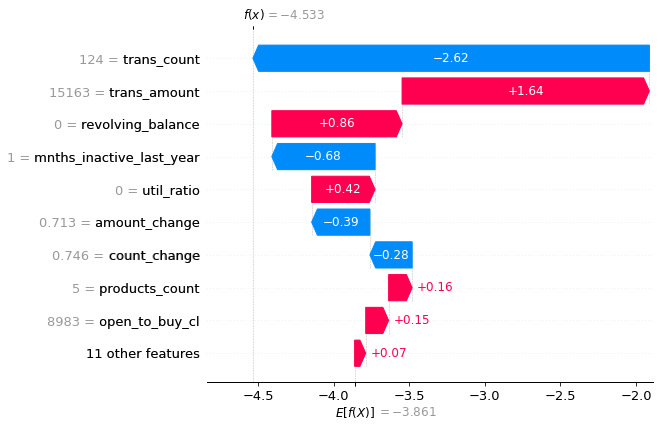

,index,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction
2,2,755305683,Blue,5,38.0,1,4,Graduate,Married,M,$60K - $80K,45,5,8983.0,15163.0,124.0,0.713,0.746,0,8983.0,0.0,0


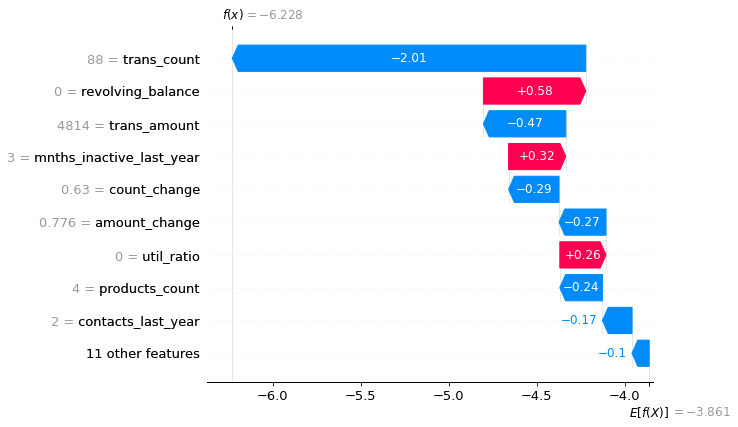

,index,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction
3,3,719147208,Blue,4,21.0,3,2,Unknown,Single,F,Less than $40K,29,2,2298.0,4814.0,88.0,0.776,0.63,0,2298.0,0.0,0


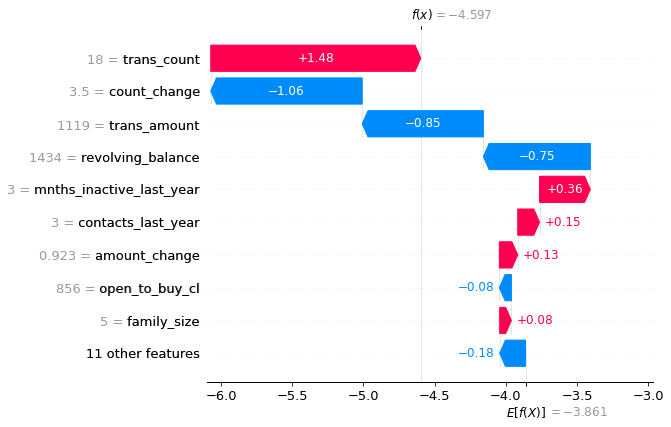

,index,customer_id,card_type,products_count,mnths_with_bank,mnths_inactive_last_year,contacts_last_year,education,martial_status,gender,earnings_bucket,age,family_size,cc_limit,trans_amount,trans_count,amount_change,count_change,revolving_balance,open_to_buy_cl,util_ratio,prediction
5,5,719942883,Blue,3,38.0,3,3,Graduate,Married,M,$60K - $80K,54,5,2290.0,1119.0,18.0,0.923,3.5,1434,856.0,0.626,0


In [32]:
# We can check 5 observations, when our model decided that those accounts will gonna stay active

idx_active = test_data[test_data['prediction'] == 0].head(5).index

for i in idx_active:
    shap.plots.waterfall(shap_values[i])
    display(test_data.iloc[[i]])

# Final notes

<h1>How could I make my model better?</h1>

* implement different method to fill empty values, maybe some model to adjust the most appropriate values 
* check different sets of features e.g., remove features which are fully correlated
* think about features which I can add e.g. create/calculate new features based on data I've already have
* try different parameters of the classification algorithm
* compare different classification algorithm: I decided to use Catboost, which is good when we have 
  some categorical features, and we do not want to worry about encoding them to numeric values
* try different ways of encoding categorical features 
* play a little more with SHAP or other expainability methods to better understand the way how our model thinks, 
  and how we can improve it 